# Importing Statements

In [124]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
import seaborn as sns
import splitfolders
import tensorflow as tf


from skimage import feature
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import svm 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow import keras
from skimage.feature import local_binary_pattern

# Splitting the Dataset

In [ ]:
input_folder = "dataset"
output_folder = "split_dataset"

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.7,0.1,0.2))
print("Dataset successfully split into training, validating and testing")

In [125]:
train_path = "split_dataset/train"
val_path = "split_dataset/val"
test_path = "split_dataset/test"  

label_names = ["2", "4", "7", "alpha", "beta", "lim", "pi","pm","theta","times"]          

# Preprocessing Data

In [126]:
def load_data(dataset_path, img_size=(28, 28)):
    data = []
    labels = []
    class_names = sorted(os.listdir(dataset_path))
    
    for label, folder in enumerate(class_names):
        folder_path = os.path.join(dataset_path, folder)
        
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                
                if image is not None:
                    image = cv2.resize(image, img_size)
                    image = image.flatten() / 255.0 
                    data.append(image)
                    labels.append(label)
                    
    return np.array(data), np.array(labels)
                      

X_train, y_train = load_data(train_path)
X_val, y_val = load_data(val_path)
X_test, y_test = load_data(test_path)

X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

In [127]:
print(f"Training images: {X_train.shape[0]}")
print(f"Validation images: {X_val.shape[0]}")
print(f"Test images: {X_test.shape[0]}")

Training images: 3500
Validation images: 500
Test images: 1000


# Implementing HOG Feature Extraction

In [128]:
def lbp_features(X, P=24, R=3, method='default', bins=256):
    lbp_features = []
    lbp_images = []

    for img in X:
        img_2d = img.reshape(28, 28)       
        lbp = local_binary_pattern(img_2d, P, R, method=method)
        hist, _ = np.histogram(lbp.ravel(), bins=bins, range=(0, bins))
        
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)
        
        lbp_features.append(hist)
        lbp_images.append(lbp)

    return np.array(lbp_features), np.array(lbp_images)

In [129]:
X_train_lbp, X_train_lbp_images = lbp_features(X_train)
X_test_lbp, X_test_lbp_images = lbp_features(X_test)
X_val_lbp, X_val_lbp_images = lbp_features(X_val)

c:\Users\Mark\Desktop\42028-Assignment-1\.venv\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


LBP Image Visualisation

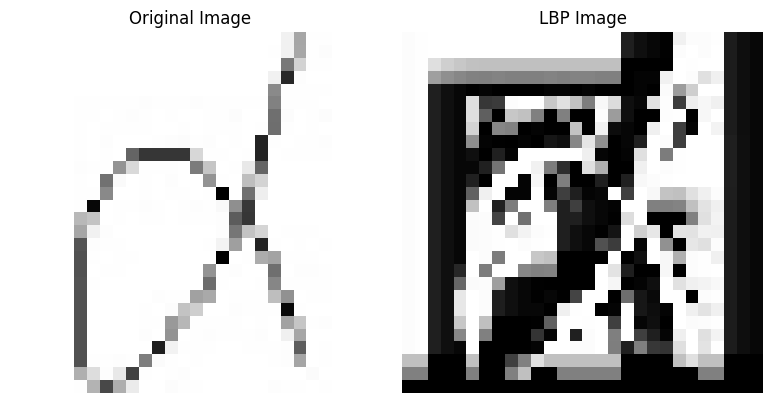

In [130]:
index = np.random.randint(0, len(X_train))

#Original Image
raw_img = X_train[index].reshape(28, 28)

#LBP Image
lbp_img = X_train_lbp_images[index]

#Plotting both images
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(raw_img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(lbp_img, cmap='gray')
plt.title("LBP Image")
plt.axis('off')

plt.tight_layout()
plt.show()

# SVM classifier

In [131]:
model_lbp = svm.SVC(kernel='rbf', C=10.0, random_state=42)
model_lbp.fit(X_train_lbp, y_train)

print("Train set Accuracy: {:.3f}".format(model_lbp.score(X_train_lbp, y_train)))

Train set Accuracy: 0.732


# SVM Results

Classification Report

In [132]:
y_pred = model_lbp.predict(X_test_lbp)

print("Classification Report (SVM-LBP):\n")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print("Final Accuracy: {:.3f}".format(accuracy))

Classification Report (SVM-LBP):

              precision    recall  f1-score   support

           0       0.40      0.35      0.37       100
           1       0.38      0.35      0.37       100
           2       0.55      0.46      0.50       100
           3       0.45      0.51      0.48       100
           4       0.53      0.67      0.59       100
           5       0.61      0.67      0.64       100
           6       0.49      0.38      0.43       100
           7       0.82      0.83      0.83       100
           8       0.38      0.42      0.40       100
           9       0.55      0.53      0.54       100

    accuracy                           0.52      1000
   macro avg       0.52      0.52      0.51      1000
weighted avg       0.52      0.52      0.51      1000

Final Accuracy: 0.517


Confusion Matrix

[[35  8  6 10  5  5  6  9 12  4]
 [ 5 35 16  5  6  3 14  4  5  7]
 [ 8 18 46  3  9  2  5  0  4  5]
 [ 1  1  1 51  9  6  0  0 19 12]
 [ 5  5  5  1 67  4  6  0  5  2]
 [ 5  1  0  8  2 67  1  2 13  1]
 [14  6  7  5 17  4 38  0  3  6]
 [ 3  6  0  3  0  0  3 83  1  1]
 [ 8  5  2 11  9 14  2  1 42  6]
 [ 4  6  1 16  3  5  2  2  8 53]]


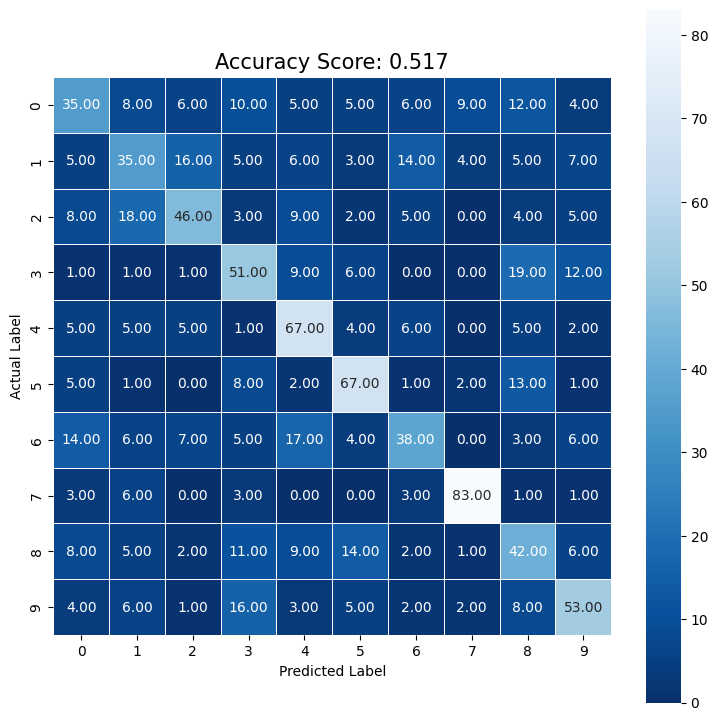

In [133]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title, size = 15);
plt.show()

Visualisation of testing data

pm
lim
lim
2


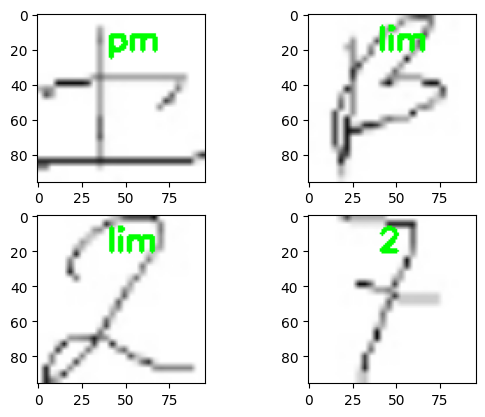

In [ ]:
pp_images = []
pp_labels = []

for i in np.random.choice(np.arange(0, len(y_test)), size=16):
    test_img = X_test[i].reshape(28, 28) * 255.0 
    test_img = test_img.astype(np.uint8)
    
    pred = model_lbp.predict(X_test_lbp[i].reshape(1, -1))[0]
    
    label = label_names[pred] if label_names else str(pred)
    pp_labels.append(label)    
    img_view = cv2.resize(test_img, (96, 96), interpolation=cv2.INTER_LINEAR)
    img_view = cv2.cvtColor(img_view, cv2.COLOR_GRAY2BGR)
    cv2.putText(img_view, label, (40, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
    pp_images.append(img_view)
    
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(pp_images[1])
print(pp_labels[1])
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(pp_images[2])
print(pp_labels[2])
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(pp_images[3])
print(pp_labels[3])
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(pp_images[4])
print(pp_labels[4])

# ANN Classifier

In [94]:
num_classes = len(np.unique(y_train))

model_lbp = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu',input_shape=(X_train_lbp.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model_lbp.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

H = model_lbp.fit(
    X_train_lbp, y_train,
    validation_data=(X_val_lbp, y_val),
    epochs=20,
    batch_size=32
)

Epoch 1/20


c:\Users\Mark\Desktop\42028-Assignment-1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1664 - loss: 2.2814 - val_accuracy: 0.2860 - val_loss: 2.1284
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3067 - loss: 2.0550 - val_accuracy: 0.3320 - val_loss: 1.8927
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3379 - loss: 1.8821 - val_accuracy: 0.3520 - val_loss: 1.8225
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3550 - loss: 1.8112 - val_accuracy: 0.3360 - val_loss: 1.7961
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3803 - loss: 1.7714 - val_accuracy: 0.3540 - val_loss: 1.7670
Epoch 6/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3716 - loss: 1.7395 - val_accuracy: 0.3720 - val_loss: 1.7432
Epoch 7/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4010 - loss: 1.7012 - val_accuracy: 0.3520 - val_loss: 1.7422
Epoch 8/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4095 - loss: 1.6804 - val_accuracy: 0.3760 - val_

# ANN Results

In [95]:
model_lbp.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,408 (489.88 KB)

 Trainable params: 41,802 (163.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 83,606 (326.59 KB)

Classification Report

In [96]:
y_pred_probs = model_lbp.predict(X_test_lbp)
y_pred_ann = np.argmax(y_pred_probs, axis=1)

print("Classification Report (ANN):")
print(classification_report(y_test, y_pred_ann))

accuracy = accuracy_score(y_test, y_pred_ann)
print("Final Accuracy: {:.3f}".format(accuracy))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Classification Report (ANN):
              precision    recall  f1-score   support

           0       0.34      0.19      0.24       100
           1       0.33      0.29      0.31       100
           2       0.42      0.40      0.41       100
           3       0.39      0.41      0.40       100
           4       0.39      0.63      0.48       100
           5       0.47      0.69      0.56       100
           6       0.17      0.03      0.05       100
           7       0.65      0.73      0.69       100
           8       0.24      0.13      0.17       100
           9       0.36      0.58      0.44       100

    accuracy                           0.41      1000
   macro avg       0.37      0.41      0.38      1000
weighted avg       0.37      0.41      0.38      1000

Final Accuracy: 0.408


Confusion Matrix

[[19  6  7 10 13 13  4 17  3  8]
 [ 1 29 13  6 15  4  3  9  1 19]
 [ 5 21 40  3 11  1  2  1  2 14]
 [ 4  3  2 41  5 18  1  3  4 19]
 [ 6  1  8  4 63  6  0  0  4  8]
 [ 1  1  1  8  5 69  1  4  7  3]
 [ 7 11 15  5 27  7  3  4 11 10]
 [ 4 12  0  1  2  2  0 73  1  5]
 [ 3  2  7 16 13 22  4  1 13 19]
 [ 6  3  2 11  7  4  0  1  8 58]]


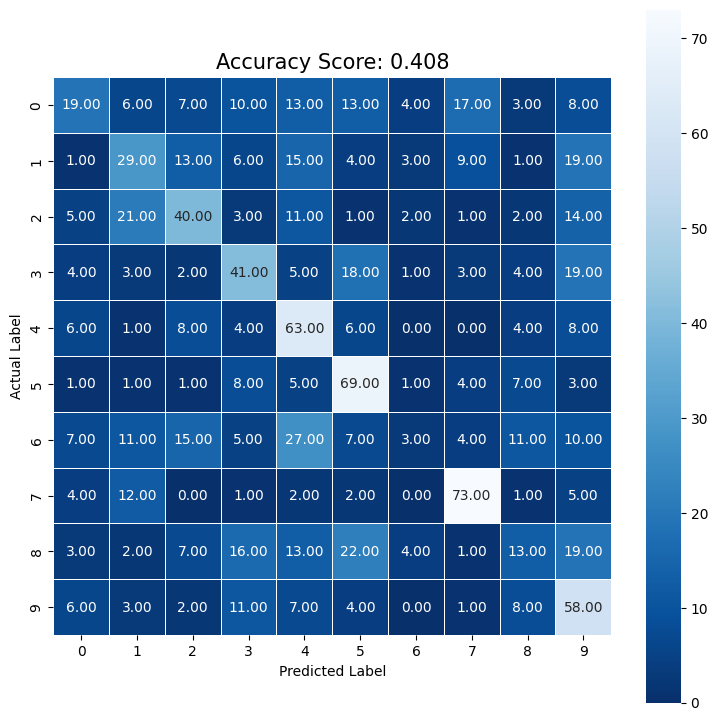

In [97]:
cm = confusion_matrix(y_test, y_pred_ann)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title, size = 15);
plt.show()